<a href="https://colab.research.google.com/github/ihagoSantos/natural-language-processing/blob/main/data_acquisition_with_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aquisição de dados com enriquecimento de dados

In [1]:
# Instalação dos pacotes
!pip install matplotlib
!pip install nlpaug
!pip install numpy
!pip install pandas
!pip install requests
!pip install scikit-learn
!pip install seaborn
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.8 MB/s eta 0:00:00


In [2]:
# funções utilitárias
import datetime
def formata_msg(nivel, msg, componente=None):
  """
  Formata uma mensagem de log incluindo o nível de severidade, timestamp, componente (opcional) e a mensagem.
  Parâmetros:
    - nível (str): Nível de severidade da mensagem(ex: 'INFO', 'ERROR', 'WARNING')
    - msg (str): A mensagem de log propriamente dita
    - componente (str, opcional): O componente ou módulo do sistema que gera a mensagem

  Retorna:
    - str: A mensagem formatada
  """
  timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
  if componente:
    return f'[{nivel}] {timestamp} - {componente}: {msg}'
  else:
    return f'[{nivel}] {timestamp}: {msg}'


def plotar_distribuicao_polaridade(df):
  """
  Função para plotar um gráfico de barras da contagem de valores da coluna 'polarity'.
  Parâmetros:
    - df (DataFrame): O dataframe da coluna 'polarity' a ser analisada

  Essa função usa a biblioteca seaborn para criar um gráfico de barras que mostra a contagem de
  ocorrências para cada valor único da coluna 'polarity'.
  Os rótulos dos eixos são removidos para uma apresentação mais limpa, e as bordas à esquerda
  também são removidas.
  """
  # realiza contagem de valores da coluna 'polarity' e armazena o resultado
  polarity_counts = df['polarity'].value_counts()

  # cria o gráfico de barras utilizando o seaborn, definindo os valores do eixo x e y
  sns.barplot(x=polarity_counts.index, y=polarity_counts, hue=polarity_counts.index, legend=False)

  # configurações do grafico
  plt.yticks([], []) # remove rótulo do eixo y para simplificar a visualização
  plt.xlabel('') # limpa o título do eixo x para uma apresentação mais limpa
  plt.ylabel('') # limpa o título do eixo y para uma apresentação mais limpa
  sns.despine(left=True) # remove a borda a esquerda do gráfico

  for container in plt.gca().containers:
    plt.gca().bar_label(container) # Adiciona os rótulos nas barras com a contagem de cada 'polarity'

print(formata_msg('INFO', f"Funções utilitárias foram declaradas, prontas para a utilização."))

[INFO] 2024-11-25 09:54:22: Funções utilitárias foram declaradas, prontas para a utilização.


In [3]:
# Importação das bibliotecas padrão
import os

# Importação das bibliotecas de terceiros
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

print(formata_msg('INFO', 'Bibliotecas importadas com sucesso; ambiente pronto.'))

[INFO] 2024-11-25 09:57:16: Bibliotecas importadas com sucesso; ambiente pronto.


In [4]:
# Define o diretório local para armazenar as bases de dados públicas coletadas
corpora_caminho = './corpora'

if not os.path.exists(corpora_caminho):
  os.mkdir(corpora_caminho)

print(formata_msg('INFO', f"Diretório {corpora_caminho} foi criado com sucesso."))

[INFO] 2024-11-25 09:59:25: Diretório ./corpora foi criado com sucesso.


# Base de dados de comentários do Buscapé

In [5]:
# Define a url pública armazenada no github
url = 'https://raw.githubusercontent.com/gomesluiz/product-review-analytics/main/data/raw/buscape.csv'

buscape_arquivo = 'buscape-comentarios.csv'

buscape_caminho = os.path.join(corpora_caminho, buscape_arquivo)

parametros = {"downloadformat": "csv"}

resposta = requests.get(url, params=parametros)

if(resposta.status_code == 200):
  with open(buscape_caminho, 'wb') as f:
    f.write(resposta.content)
  print(formata_msg('INFO', f'Download do arquivo {buscape_arquivo} concluído com sucesso!'))

else:
  print(formata_msg('ERROR', f'Falha no download do arquivo {buscape_arquivo}: {resposta.status_code}'))

[INFO] 2024-11-25 10:04:41: Download do arquivo buscape-comentarios.csv concluído com sucesso!


In [6]:
# O comando head do linux mostra as cinco primeiras linhas do arquivo gravado
!head -n 10 {buscape_caminho}

original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
4_55516,"Estou muito satisfeito, o visor é melhor do que eu imaginava, boas imagens, desing ultra fino. Pelo preço é um exelente aparelho.

O que gostei: Desing exelente, display, custo beneficio.

O que não gostei: Não tem como adicionar mais papeis de parede, bateria dura pouco.","estou muito satisfeito, o visor e melhor do que eu imaginava, boas imagens, desing ultra fino. pelo preco e um exelente aparelho.

o que gostei: desing exelente, display, custo beneficio.

o que nao gostei: nao tem como adicionar mais papeis de parede, bateria dura pouco.","['estou', 'muito', 'satisfeito', 'visor', 'melhor', 'do', 'que', 'eu', 'imaginava', 'boas', 'imagens', 'desing', 'ultra', 'fino', 'pelo', 'preco', 'um', 'exelente', 'aparelho', 'que', 'gostei', 'desing', 'exelente', 'display', 'custo', 'beneficio', 'que', 'nao', 'gostei', 'nao', 'tem', 'como', 'adicionar', 'mais', 'papeis', 

In [9]:
# Lista com colunas específicas para serem lidas do arquivo CSV
colunas_desejadas = ['review_text', 'polarity']
# carrega dados csv usando as colunas definidas
buscape_df = pd.read_csv(buscape_caminho, usecols=colunas_desejadas)

# mostra número de linhas e colunas do dataframe buscape_df
[num_rows, num_cols] = buscape_df.shape
print(formata_msg('INFO', f"O dataset tem {num_rows} linhas e {num_cols} colunas."))

[INFO] 2024-11-25 10:09:06: O dataset tem 84991 linhas e 2 colunas.


In [10]:
# remove todas as linhas do DataFrame que contém valores nulos
buscape_df.dropna(inplace=True)

# mostra número de linhas e colunas do dataframe buscape_df
[num_rows, num_cols] = buscape_df.shape
print(formata_msg('INFO', f"O dataset tem {num_rows} linhas e {num_cols} colunas."))

[INFO] 2024-11-25 10:11:33: O dataset tem 73626 linhas e 2 colunas.


In [11]:
# Exibe as 5 primeiras linhas do Dataframe
buscape_df.head()

,review_text,polarity
0,"Estou muito satisfeito, o visor é melhor do qu...",1.0
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",1.0
2,"Rápida, ótima qualidade de impressão e fácil d...",1.0
3,Produto de ótima qualidade em todos os quesito!,1.0
4,Precisava comprar uma tv compatível com meu dv...,1.0


In [12]:
# Converte os valores da coluna 'polarity' para int
buscape_df['polarity'] = buscape_df['polarity'].astype(int)

buscape_df.head()

,review_text,polarity
0,"Estou muito satisfeito, o visor é melhor do qu...",1
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",1
2,"Rápida, ótima qualidade de impressão e fácil d...",1
3,Produto de ótima qualidade em todos os quesito!,1
4,Precisava comprar uma tv compatível com meu dv...,1


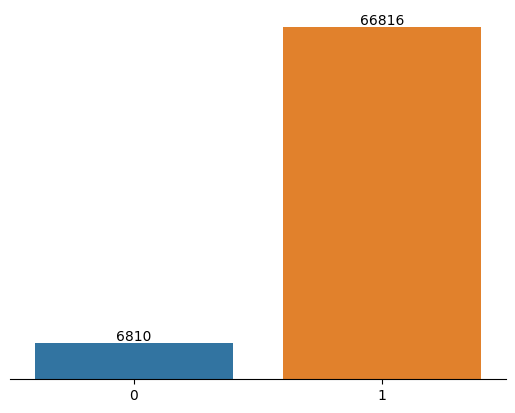

In [13]:
# Plota um gráfico de barras com as categorias de polaridade
plotar_distribuicao_polaridade(buscape_df)

In [18]:
# Seleciona uma linha específica do dataframe 'buscape_df' usando 'iloc' para
# testes do enriquecimento de dados.
texto = buscape_df.iloc[5]['review_text'].replace('\n', ' ')
texto

'eu adorei este secador é muito bom,potente e deixa meu cabelo lindo'

In [21]:
# Iniciando o aumentador de dados com o modelo BERT em português
# para inserir palavras contextualmente apropriadas
enriquecedor = naw.ContextualWordEmbsAug(
    model_path='neuralmind/bert-base-portuguese-cased', action='insert'
)

print("Exibindo o texto original:")
print(texto)

# Exibindo o texto enriquecido
print("Texto enriquecido")
for ii in range(5):
  print(enriquecedor.augment(texto))

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Exibindo o texto original:
eu adorei este secador é muito bom,potente e deixa meu cabelo lindo
Texto enriquecido
['eu sempre adorei este seu secador solar é muito bom, potente e leve deixa meu novo cabelo mega lindo']
['Cara eu realmente adorei este secador é sim muito bom, potente potente e deixa realmente meu cabelo todo lindo']
['eu mesmo adorei este seu secador pois é muito bom, potente protege e deixa muito meu cabelo simplesmente lindo']
['nossa eu adorei este secador é demais muito gente bom, potente forte e super deixa meu cabelo bem lindo']
['eu adorei este seu secador porque é lá muito bem bom, potente serve e deixa realmente meu cabelo lindo']


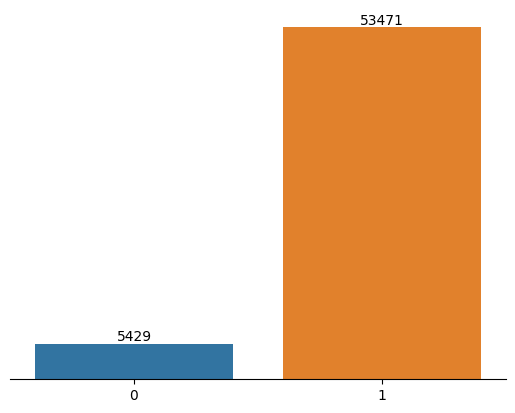

In [22]:
# Divisão do DataFrame buscape_df em conjuntos de treino e teste
train, test = train_test_split(buscape_df, test_size=0.20, random_state=42)

# Plotar distribuição e polaridade no conjunto de treino
plotar_distribuicao_polaridade(train)

In [24]:
def enriquecer_texto(enriquecedor, df, classe, amostras=100, prob_aug=0.2):
  """
  Enriquece textos de uma determinada classe em um DataFrame usando enriquecimento.

  A Função seleciona aleatoriamente um conjunto de textos da classe especificada
  e aplica a augmentação para gerar novos textos. Esses textos são adicionados ao
  DataFrame original, criando uma versão enriquecida do mesmo.

  Args:
  - enriquecedor: Objeto utilizado para realizar a augmentação de dados
  - df (pd.DataFrame): DataFrame contendo os textos e suas respectivas classes.
  - classe (int/str): A classe dos textos que serão enriquecidos.
  - amostra: (int/opcional): Número de textos da classe especificada a serem enriquecidos.
  - prob_aug: (float/ opcional): Probabilidade de cada palavra ser augmentada. Padrão é 0.2.

  Returns:
  - pd.DataFrame: DataFrame original com os textos enriquecidos adicionados, embaralhado de forma aleatória.
  """

  # Define a probabilidade de augmentação para o enriquecedor
  enriquecedor.aug_p = prob_aug
  # inicializa lista para armazenar textos enriquecidos
  textos_enriquecidos = []
  # Filtra o DataFrame para obter apenas as entradas da classe especificada
  df_minoritario = df[df.polarity == classe].reset_index(drop=True)

  # Loop para enriquecer uma quantidade específica de amostras aleatórias
  for i in tqdm(np.random.randint(0, len(df_minoritario), amostras)): # a função tqdm mostra o progresso visualmente
    texto = df_minoritario.iloc[i]['review_text']
    texto_enriquecido = enriquecedor.augment(texto)
    textos_enriquecidos.append(texto_enriquecido)

  # Cria um dataframe com os textos enriquecidos e a classe-alvo
  df_enriquecido = pd.DataFrame({'review_text': textos_enriquecidos, 'polarity': classe})

  # Combina o DataFrame original com o DataFrame enriquecido e embaralha
  df_resultante = pd.concat([df, df_enriquecido], ignore_index=True).sample(frac=1, random_state=42)

  #retorna o DataFrame resultante
  return df_resultante

print(formata_msg('INFO', f'Função de enriquecimento pronta para utilização.'))

[INFO] 2024-11-25 10:40:32: Função de enriquecimento pronta para utilização.


100%|██████████| 10/10 [01:56<00:00, 11.64s/it]

[INFO] 2024-11-25 10:46:03: Dataset de treinamento enriquecido.


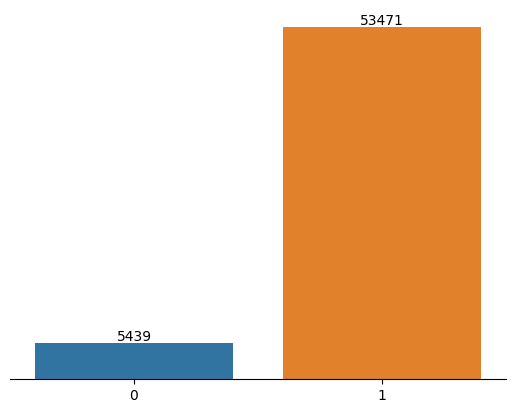

In [26]:
# Enriquece o conjunto de treinamento.
# Esse procedimento não deve ser aplicado ao conjunto de teste.
# Esse deve refletir os dados do mundo real tão fielmente quanto possível.
train_enriquecido = enriquecer_texto(enriquecedor, train, 0, amostras=10)
print(formata_msg('INFO', f'Dataset de treinamento enriquecido.'))

# plotar a distribuição de polaridade no conjunto de treino
# após o enriquecimento.

plotar_distribuicao_polaridade(train_enriquecido)